## Домашнее задание 5

#### Задание 1.

Сформировать с помощью sklearn.make_classification датасет из 1000 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50, 100, 200 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote). Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

#### Задание 2.

Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_samples=1000, n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, flip_y=.5, random_state=1)

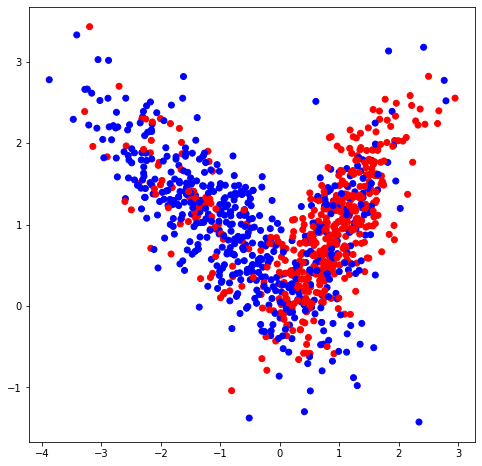

In [3]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)
plt.show()

*Инициализируем классы узла, листа и дерева классификации с прошлого урока:*

In [4]:
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле


class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        


class DTC:
    
    def __init__(self, min_leaf=1, criterion='gini', max_depth=None, max_leaf_count=None):
        self.min_leaf = min_leaf
        self.criterion = criterion
        self.max_depth = max_depth
        self.max_leaf_count = max_leaf_count 
        self._tree = None # дерево решений
        self.tasks = [] # список задач для создания дерева 'сначала вширь'
        self.nodes = [{ # список узлов для создания дерева 'сначала вширь'
            'id_': 0,
            'parent_id': None,
            't': None,
            'index': None,
            'is_left': None,
            'is_node': True
        }]
        self.leaf_count = 0 # счетчик листьев
        
    
    def _criterion(self, labels):
        #  подсчет количества объектов разных классов
        classes = {}
        for label in labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1

        #  расчет критерия
        if self.criterion == 'gini':
            impurity = 1
            for label in classes:
                p = classes[label] / len(labels)
                impurity -= p ** 2
        elif self.criterion == 'shannon':
            impurity = 0
            for label in classes:
                p = classes[label] / len(labels)
                part = p * np.log2(p) if p else 0
                impurity -= part

        return impurity  
    
    
    def _quality(self, left_labels, right_labels, current_criterion):

        # доля выбоки, ушедшая в левое поддерево
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

        return current_criterion - p * self._criterion(left_labels) - (1 - p) * self._criterion(right_labels)

    
    def _split(self, data, labels, index, t):

        left = np.where(data[:, index] <= t)
        right = np.where(data[:, index] > t)

        true_data = data[left]
        false_data = data[right]
        true_labels = labels[left]
        false_labels = labels[right]

        return true_data, false_data, true_labels, false_labels
    
    
    def _find_best_split(self, data, labels):

        current_criterion = self._criterion(labels)

        best_quality = 0
        best_t = None
        best_index = None

        n_features = data.shape[1]

        for index in range(n_features):
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique([row[index] for row in data])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self._split(data, labels, index, t)
                #  пропускаем разбиения, в которых в узле остается менее 5 объектов
                if len(true_data) < self.min_leaf or len(false_data) < self.min_leaf:
                    continue

                current_quality = self._quality(true_labels, false_labels, current_criterion)

                #  выбираем порог, на котором получается максимальный прирост качества
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index

        return best_quality, best_t, best_index
    
    
    def _build_tree(self, data, labels, level=0, id_=0):

        quality, t, index = self._find_best_split(data, labels)
        
        # Проверяем, что сумма количества листьев и узлов в списке вместе с текущей задачей меньше self.max_leaf_count:
        if self.max_leaf_count is not None:
            max_leaf_flag = False if self.leaf_count + len(self.tasks) + 1 < self.max_leaf_count else True
        else:
            max_leaf_flag = False

        #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества или дерево достигло максимальной глубины,
        # или количество листьев больше или равно максимальному
        if quality == 0 or level == self.max_depth or max_leaf_flag:
            self.leaf_count += 1
            for itm in self.nodes:
                if itm['id_'] == id_:
                    itm['is_node'] = False
                    itm['data'] = data
                    itm['labels'] = labels
            if len(self.tasks):
                self._build_tree(*self.tasks.pop(0))
        else:
            true_data, false_data, true_labels, false_labels = self._split(data, labels, index, t)
            for itm in self.nodes:
                if itm['id_'] == id_:
                    itm['t'] = t
                    itm['index'] = index

            # Добавляем в список задач и список узлов две ветки поддерева
            level += 1
            current_len = len(self.nodes)
            self.tasks.append([true_data, true_labels, level, current_len])
            self.tasks.append([false_data, false_labels, level, current_len + 1])
            self.nodes.append({
                'id_': current_len,
                'parent_id': id_,
                't': None,
                'index': None,
                'is_left': True,
                'is_node': True
            })
            self.nodes.append({
                'id_': current_len + 1,
                'parent_id': id_,
                't': None,
                'index': None,
                'is_left': False,
                'is_node': True
            })


            self._build_tree(*self.tasks.pop(0))

    
    def _create_instance(self, id_=0): # функция создания дерева по списку узлов self.nodes
        for itm in self.nodes:
            if itm['id_'] == id_:
                if itm['is_node']:
                    index = itm['index']
                    t = itm['t']
                    break
                else:
                    return Leaf(itm['data'], itm['labels'])
        for itm in self.nodes:
            if itm['parent_id'] == id_ and itm['is_left']:
                true_branch = self._create_instance(itm['id_'])
            if itm['parent_id'] == id_ and not itm['is_left']:
                false_branch = self._create_instance(itm['id_'])
        
        return Node(index, t, true_branch, false_branch)
    
    
    def fit(self, data, labels):
        self._build_tree(data, labels, 0, 0)
        self._tree = self._create_instance()
        
        
    def _classify_object(self, obj, node):

        #  Останавливаем рекурсию, если достигли листа
        if isinstance(node, Leaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self._classify_object(obj, node.true_branch)
        else:
            return self._classify_object(obj, node.false_branch)
    
    
    def predict(self, data):

        classes = []
        for obj in data:
            prediction = self._classify_object(obj, self._tree)
            classes.append(prediction)
        return classes
    
    
    def print_tree(self):
        node = self._tree
        self._print_nodes(node)
    
    
    def _print_nodes(self, node, spacing=""):

        # Если лист, то выводим его прогноз
        if isinstance(node, Leaf):
            print(spacing + "Прогноз:", node.prediction)
            return

        # Выведем значение индекса и порога на этом узле
        print(spacing + 'Индекс', str(node.index))
        print(spacing + 'Порог', str(node.t))

        # Рекурсионный вызов функции на положительном поддереве
        print (spacing + '--> True:')
        self._print_nodes(node.true_branch, spacing + "  ")

        # Рекурсионный вызов функции на положительном поддереве
        print (spacing + '--> False:')
        self._print_nodes(node.false_branch, spacing + "  ")



*Инициализируем класс дерева классификации для рандомного леса. Класс наследуется от дерева классификации, нужно переопределить функцию _find_best_split, и добавить функцию _get_subsample:*

In [5]:
class Forest_Tree(DTC):
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    
    def _get_subsample(self, len_sample):
        # будем сохранять не сами признаки, а их индексы
        sample_indexes = [i for i in range(len_sample)]

        len_subsample = int(np.sqrt(len_sample))
        subsample = []

        random.shuffle(sample_indexes)
        for _ in range(len_subsample):
            subsample.append(sample_indexes.pop())

        return subsample
    
    
    def _find_best_split(self, data, labels):

        current_criterion = self._criterion(labels)

        best_quality = 0
        best_t = None
        best_index = None

        n_features = data.shape[1]
        
        # выбор индекса из подвыборки длиной sqrt(n_features)
        subsample = self._get_subsample(n_features)

        for index in subsample:
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique([row[index] for row in data])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self._split(data, labels, index, t)
                #  пропускаем разбиения, в которых в узле остается менее 5 объектов
                if len(true_data) < self.min_leaf or len(false_data) < self.min_leaf:
                    continue

                current_quality = self._quality(true_labels, false_labels, current_criterion)

                #  выбираем порог, на котором получается максимальный прирост качества
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index

        return best_quality, best_t, best_index
    

*Создадим класс рандомного леса. Также добавим сразу расчет ошибки по методу Out Of Bag. Так как модель предсказывает сразу метку класса, а не вероятность, нет смысла использовать logloss: при ошибке предсказания мы получим либо бесконечность, либо, если ограничить логарифм, получим некое константное значение. При правильном же предсказании ошибка будет равна нулю. Тогда сразу можно вместо вычисления логарифма при ошибке ставить 1, а при совпадении меток 0. Потом рассчитываем среднюю ошибку oob_err. Причем 1 - oob_err будет неким аналогом метрики  Accuracy, расчитанный по методу OOB.*

In [6]:
class RFC:
    
    def __init__(self, min_leaf=1, criterion='gini', max_depth=None, max_leaf_count=None, n_trees=1):
        self.min_leaf = min_leaf
        self.criterion = criterion
        self.max_depth = max_depth
        self.max_leaf_count = max_leaf_count
        self.n_trees = n_trees
        self.trees = [] # список деревьев
        self.out_of_bag_error = []
        random.seed(42)
        
    
    def _get_bootstrap(self, data, labels):
        n_samples = data.shape[0]
        indexes = set([i for i in range(n_samples)])
        bootstrap = []
        out_of_bag = []

        for i in range(self.n_trees):
            b_data = np.zeros(data.shape)
            b_labels = np.zeros(labels.shape)
            used_indexes = []  # массив использованных индексов
            for j in range(n_samples):
                sample_index = random.randint(0, n_samples-1)
                b_data[j] = data[sample_index]
                b_labels[j] = labels[sample_index]  
                used_indexes.append(sample_index) # добавляем используемые индексы в массив
            unused_indexes = indexes - set(used_indexes) # создаем множество неиспользованных индексов
            out_of_bag.append(unused_indexes) # добавляем для каждого дерева множество неиспользованных индексов
            bootstrap.append((b_data, b_labels))

        return bootstrap, out_of_bag
    
    
    def fit(self, data, labels):
        bootstrap, out_of_bag = self._get_bootstrap(data, labels)
        n_samples = data.shape[0]
        
        # Обучение на bootstrap-выборках деревьев и добавление их в список деревьев леса
        for b_data, b_labels in bootstrap:
            tree = Forest_Tree(min_leaf=self.min_leaf, 
                               criterion=self.criterion, 
                               max_depth=self.max_depth, 
                               max_leaf_count=self.max_leaf_count)
            tree.fit(b_data, b_labels)
            self.trees.append(tree)
        
        # Получение для каждого объекта выборки усредненных предсказаний неиспользованных деревьев:
        for idx1 in range(n_samples):
            predictions = []
            for idx2 in range(self.n_trees): # проходимся по каждому дереву
                if idx1 in out_of_bag[idx2]: # если дерево не обучалось на объекте, добавляем предсказание
                    predictions.append(*self.trees[idx2].predict([data[idx1]]))
            if predictions: # некоторые объекты выборки могут попасть во все деревья
                if labels[idx1] == max(set(predictions), key=predictions.count): # сравниваем таргет с усредненным предсказанием
                    self.out_of_bag_error.append(0) # добавляем ошибку для каждого объекта выборки
                else:
                    self.out_of_bag_error.append(1)
        
        
    def predict(self, data):
        
        # добавим предсказания всех деревьев в список
        predictions = []
        for tree in self.trees:
            predictions.append(tree.predict(data))
        
        # сформируем список с предсказаниями для каждого объекта
        predictions_per_object = list(zip(*predictions))

        # выберем в качестве итогового предсказания для каждого объекта то,
        # за которое проголосовало большинство деревьев
        voted_predictions = []
        for obj in predictions_per_object:
            voted_predictions.append(max(set(obj), key=obj.count))

        return voted_predictions
    
    def get_out_of_bag_error(self):
        return np.mean(self.out_of_bag_error)

In [7]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [8]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

*Обучим рандомный лес для одного дерева, а таже установим минимальное количество объектов в листе, равным 5:*

In [9]:
rfc = RFC(
    min_leaf=5, 
#     criterion='shannon', 
#     max_depth=4,
#     max_leaf_count=3,
    n_trees=1
)
rfc.fit(train_data, train_labels)
train_answers = rfc.predict(train_data)
answers = rfc.predict(test_data)

In [10]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

def draw_separating_plane(train_data, test_data, train_labels, test_labels, train_answers, answers):
    train_accuracy = accuracy_metric(train_labels, train_answers)
    test_accuracy = accuracy_metric(test_labels, answers)
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(rfc.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')
    plt.show()

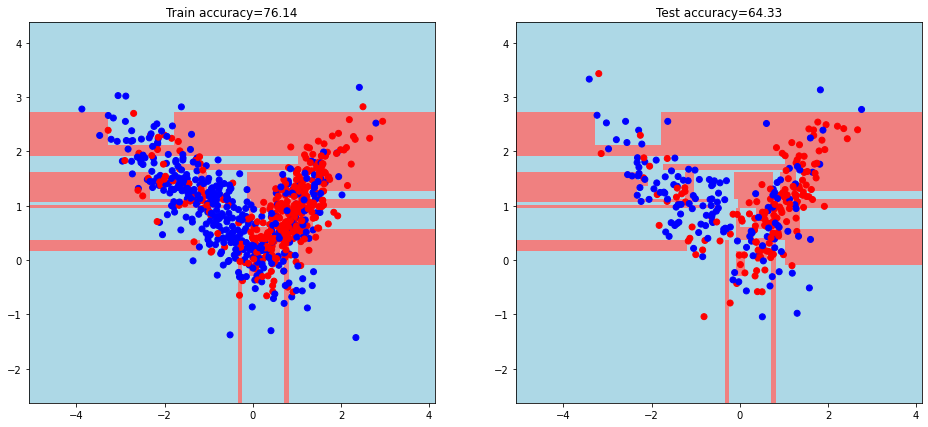

In [11]:
draw_separating_plane(train_data, test_data, train_labels, test_labels, train_answers, answers)

*Теперь обучим модель с 3-мя деревьями:*

In [12]:
rfc = RFC(
    min_leaf=5, 
#     criterion='shannon', 
#     max_depth=4,
#     max_leaf_count=3,
    n_trees=3
)
rfc.fit(train_data, train_labels)
train_answers = rfc.predict(train_data)
answers = rfc.predict(test_data)

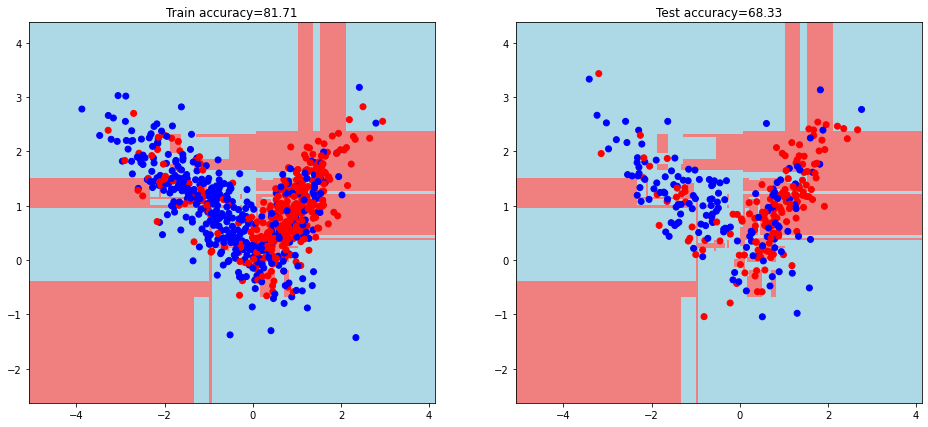

In [13]:
draw_separating_plane(train_data, test_data, train_labels, test_labels, train_answers, answers)

*Теперь для 10 деревьев:*

In [14]:
rfc = RFC(
    min_leaf=5, 
#     criterion='shannon', 
#     max_depth=4,
#     max_leaf_count=3,
    n_trees=10
)
rfc.fit(train_data, train_labels)
train_answers = rfc.predict(train_data)
answers = rfc.predict(test_data)

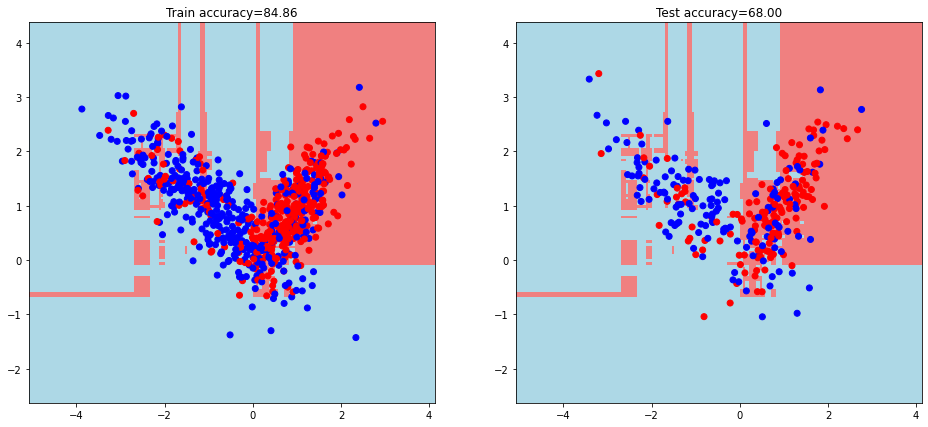

In [15]:
draw_separating_plane(train_data, test_data, train_labels, test_labels, train_answers, answers)

*Для 50:*

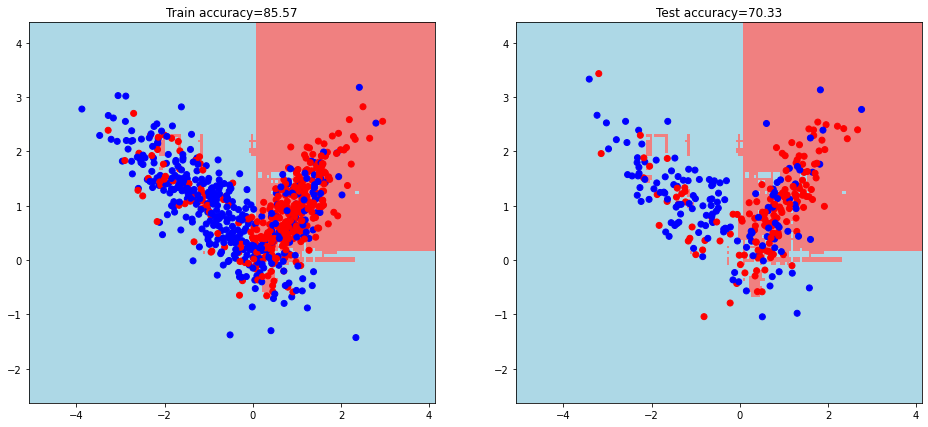

In [16]:
rfc = RFC(
    min_leaf=5, 
#     criterion='shannon', 
#     max_depth=4,
#     max_leaf_count=3,
    n_trees=50
)
rfc.fit(train_data, train_labels)
train_answers = rfc.predict(train_data)
answers = rfc.predict(test_data)
draw_separating_plane(train_data, test_data, train_labels, test_labels, train_answers, answers)

*Для 100:*

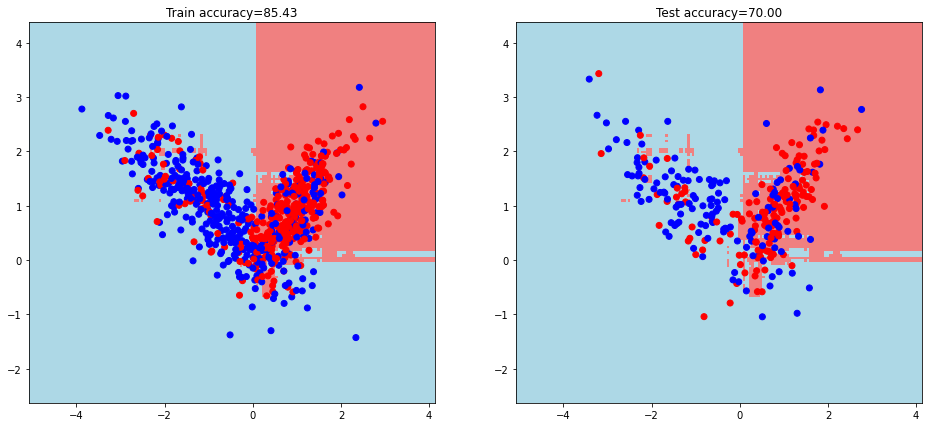

In [17]:
rfc = RFC(
    min_leaf=5, 
#     criterion='shannon', 
#     max_depth=4,
#     max_leaf_count=3,
    n_trees=100
)
rfc.fit(train_data, train_labels)
train_answers = rfc.predict(train_data)
answers = rfc.predict(test_data)
draw_separating_plane(train_data, test_data, train_labels, test_labels, train_answers, answers)

*И для 200:*

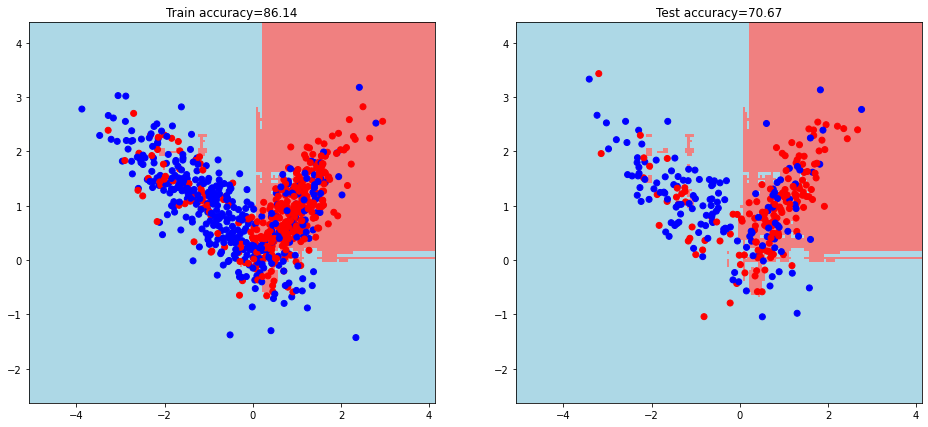

In [18]:
rfc = RFC(
    min_leaf=5, 
#     criterion='shannon', 
#     max_depth=4,
#     max_leaf_count=3,
    n_trees=200
)
rfc.fit(train_data, train_labels)
train_answers = rfc.predict(train_data)
answers = rfc.predict(test_data)
draw_separating_plane(train_data, test_data, train_labels, test_labels, train_answers, answers)

**Выводы:**

- При увеличении деревьев сначала увеличивается качество классификации
- Начиная с 50 деревьев, метрика повышается незначительно, а при 100 деревьях даже падает
- Но при 200 деревьях метрика все равно наибольшая. Визуально видно, что алгоритм хорошо проводит классификацию, переобучения практически нет (мало малых областей одного класса на большой области другого)
- Разница между метриками на трейне и тесте не говорит о переобучении, это предел самих данных и такого разбиения.

## Out Of Bag Error

*Обучим леса с таким же количеством деревьев, но на всей выборке без разбиения. Получим oob_err и вычислим аналог accuracy по методу Out Of Bag:*

In [19]:
def out_of_bag_metric(classification_data, classification_labels, n_trees):
    rfc = RFC(
        min_leaf=5, 
    #     criterion='shannon', 
    #     max_depth=4,
    #     max_leaf_count=3,
        n_trees=n_trees
    )
    rfc.fit(classification_data, classification_labels)
    oob_acc = (1 - rfc.get_out_of_bag_error())*100
    print(f'Кроличество деревьев: {n_trees}\nAccuracy по методу Out Of Bag: {oob_acc}')

In [20]:
out_of_bag_metric(classification_data, classification_labels, 1)

Кроличество деревьев: 1
Accuracy по методу Out Of Bag: 61.15702479338842


In [21]:
out_of_bag_metric(classification_data, classification_labels, 3)

Кроличество деревьев: 3
Accuracy по методу Out Of Bag: 65.65789473684211


In [22]:
out_of_bag_metric(classification_data, classification_labels, 10)

Кроличество деревьев: 10
Accuracy по методу Out Of Bag: 67.67676767676767


In [23]:
out_of_bag_metric(classification_data, classification_labels, 50)

Кроличество деревьев: 50
Accuracy по методу Out Of Bag: 70.7


In [24]:
out_of_bag_metric(classification_data, classification_labels, 100)

Кроличество деревьев: 100
Accuracy по методу Out Of Bag: 69.5


In [25]:
out_of_bag_metric(classification_data, classification_labels, 200)

Кроличество деревьев: 200
Accuracy по методу Out Of Bag: 70.30000000000001


*Напомним метки accuracy, рассчитанные по отложенной выборке: 64.33, 68.33, 68.00, 70.33, 70.00, 70.67*

*Как видно, оценка качества модели по OOB довольно близка к оценке по отложенной выборке. И также позоляет сделать вывод - для данной выборки увеличение деревьев больше 50 не дает заметного прироста в качестве.*